In [5]:
%matplotlib inline

import wikipedia as wp
import pandas as pd 

import requests
import io

from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
pip install shapely

     |████████████████████████████████| 1.5MB 16.9MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install geopandas

     |████████████████████████████████| 921kB 14.8MB/s eta 0:00:01
     |████████████████████████████████| 11.8MB 16.9MB/s eta 0:00:01
     |████████████████████████████████| 81kB 18.0MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
html = wp.page("List of postal codes of Canada: M").html().encode("UTF-8")

# determine the index of your table
df = pd.read_html(html, header = 0)[0]

In [7]:
# Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
df = df[df.Borough != 'Not assigned']

# More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
df = df.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index()

# If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.
for index, row in df.iterrows():
    if row['Neighbourhood'] == 'Not assigned':
        row['Neighbourhood'] = row['Borough']

In [8]:
# Use Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.
url="http://cocl.us/Geospatial_data"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))

# rename the first column to allow merging dataframes on Postcode
c.columns = ['Postcode', 'Latitude', 'Longitude']
df = pd.merge(c, df, on='Postcode')

# reorder column names and show the dataframe
df = df[['Postcode', 'Borough', 'Neighbourhood', 'Latitude', 'Longitude']]

# load latitude and longitude into geopandas dataframe
df['Coordinates'] = list(zip(df.Longitude, df.Latitude))
df['Coordinates'] = df['Coordinates'].apply(Point)
gdf = gpd.GeoDataFrame(df, geometry='Coordinates')


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


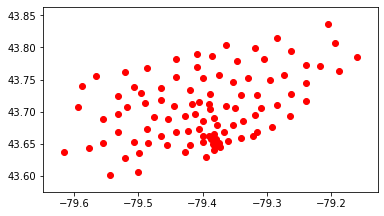

In [9]:
# Drawing cluster Map
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
ax = cities[cities.name == "Toronto"].plot(
    color='white', edgecolor='black')

# plot and show
gdf.plot(ax=ax, color='red')
plt.show()